In [18]:
import sys
import time

import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj

from pygsp.graphs import Graph
import networkx as nx

# For unrolling
# sys.path.insert(0, './GUN')

sys.path.insert(0, '..')
from graph_deep_decoder import datasets as ds
from graph_deep_decoder import utils
from graph_deep_decoder.model import select_model, Model
from graph_deep_decoder.architecture import Ups
from graph_deep_decoder.graph_clustering import MultiResGraphClustering

SEED = 0
PATH = './results/real_data/'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

print(device)

cuda:0


## Auxiliary functions

In [19]:
def get_best_err(err):
    mean_err = np.mean(err, axis=1)
    std = np.std(err, axis=1)
    best_epochs_mean = np.argmin(mean_err, axis=2)
    best_mean_err = np.zeros((len(N_P), len(Exps)))
    best_std = np.zeros((len(N_P), len(Exps)))
    for i in range(len(N_P)):
        for j in range(len(Exps)):
            best_mean_err[i, j] = mean_err[i, j, best_epochs_mean[i, j]]
            best_std[i, j] = std[i, j, best_epochs_mean[i, j]]

    return best_mean_err, best_std, best_epochs_mean,

def print_err(err, std, weights):
    print('N_P:', N_P)
    for j, exp in enumerate(Exps):
        text = '{} ({}): '.format(exp['legend'], weights[j])
        for i, n_p in enumerate(N_P):
            text += '\t{:.4f} +- {:.4f}'.format(err[i, j], std[i, j]) 
        print(text)

def print_err_all0(labels):
    x_zero = np.zeros(labels.shape[0])
    err = np.zeros(np.unique(labels).shape[0])
    for label in labels:
        x = np.where(labels == label, 1, 0)
        err[label-1] = np.sum(x != x_zero)/labels.shape[0]

    print('Err per label:', err)
    print('Mean Err:', np.mean(err))

def compute_matrices(Exps, plot_clts=False):
    for exp in Exps:
        if exp['type'] == 'DD' and exp['legend'] == 'GD':
            clt = MultiResGraphClustering(G, exp['nodes'], exp['nodes'][0], link_fun='average')
            exp['nodes'] = clt.sizes
            exp['Us'] = clt.Us
            exp['As'] = clt.As

            if plot_clts:
                clt.plot_labels()

        elif exp['type'] == 'DD' and exp['legend'] == 'GCG':
            H = utils.create_filter(S, exp['h_params'])
            exp['Us'] =[H]*(len(exp['nodes'])-2) + [None]
            exp['As'] = []

        elif exp['type'] == 'UNROLLING':
            G_nx = nx.from_numpy_array(S) 
            adj = nx.adjacency_matrix(G_nx, nodelist=sorted(G_nx.nodes)).astype(float)
            exp['adj'] = utils.to_torch_sparse(adj.astype(np.float32)) 
            if 'GUTF' in exp['arch']:
                G_nx = nx.from_numpy_array(np.sqrt(A))
                Delta = nx.linalg.graphmatrix.incidence_matrix(G_nx).todense().T
                exp['Delta'] = torch.Tensor(Delta).to(device)
            else:
                exp['Delta'] = None

def denoise_signals(labels, n_signals, Exps, epochs, lr):
    unique_labels = np.unique(labels)
    print('Labels:', unique_labels)
    n_labels = len(unique_labels)

    err = np.zeros((len(N_P), n_labels*n_signals, len(Exps), epochs))
    weights = np.zeros(len(Exps))
    for i, n_p in enumerate(N_P):
        print('Noise:', n_p)

        for l, label in enumerate(unique_labels):
            x = np.zeros(G.N)
            x[labels == label] = 1

            for j in range(n_signals):
                idx = l*n_signals + j
                x_n = ds.GraphSignal.add_bernoulli_noise(x, n_p)

                for k, exp in enumerate(Exps):
                    model = select_model(exp, x_n, epochs, lr, device)
                    if type(model) == Model:
                        weights[k] = model.count_params()
                        if 'adj' in exp.keys():
                            x_n_tensor = torch.Tensor(x_n).reshape((x_n.size, 1))
                            _, err[i, idx, k], _ = model.fit(x_n_tensor, x, class_val=True,
                                                           device=device, adj_list=exp['adj'])
                        else:
                            _, err[i, idx, k], _ = model.fit(x_n, x, class_val=True, device=device)
                    else:
                        model.fit(x_n)
                        _, err_non_train = model.test_classification(x)
                        err[i, idx, k] = np.repeat(err_non_train, epochs)

                print(f'({l},{j})', end=' ')
    return err, weights

## Load dataset (whole graph)

In [20]:
dataset = Planetoid(root='./tmp/Cora', name='Cora')
data = dataset[0]

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of classes: {dataset.num_classes}')

A = to_dense_adj(data.edge_index).numpy()[0,:,:]
L = np.diag(np.sum(A, axis=0)) - A
lambdas, V = np.linalg.eigh(L)
lambdas = np.real(lambdas)
print('Conn Comp:', np.sum(np.abs(lambdas) <= 1e-6))

labels = data.y

S = A

G = Graph(A)
G.set_coordinates()
# plt.figure()
# G.plot_signal(labels.numpy())
# plt.title('Original graph')


Number of nodes: 2708
Number of edges: 10556
Number of classes: 7
Conn Comp: 78


## Set the expetiments

In [21]:
N_P = [.3]

# Model parameters
epochs =  500
lr = 0.001
loss = nn.MSELoss

Exps = [
        # {'type': 'BL', 'S': A, 'alpha': .05, 'legend': 'BL'},
        # {'type': 'TV', 'A': A, 'alpha': 5, 'legend': 'TV'},        
        # {'type': 'LR', 'L': L, 'alpha': 15, 'legend': 'LR'},
        # {'type': 'GTF', 'A': A, 'k': 3, 'lamb': .25, 'legend': 'GTF'},

        # # Non-convex
        # {'type': 'MED', 'S': A, 'legend': 'MED'},
        # {'type': 'GCNN', 'fts': 75, 'A': A, 'last_fts': 1, 'last_act': nn.Sigmoid(),
        #  'loss': loss(reduction='none'), 'legend': 'GCNN'},
        # {'type': 'GAT', 'fts': 70, 'A': A, 'heads': 3, 'last_fts': 1, 'last_act': nn.Sigmoid(),
        #  'loss': loss(reduction='none'), 'legend': 'GAT'},
        # {'type': 'KronAE', 'fts': 50, 'A': A, 'r': .5, 'last_act': nn.Sigmoid(),
        #  'loss': loss(reduction='none'), 'legend': 'K-GAE'},

        # Our models
        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*4, 'fts': [100]*3 + [1],
         'af': nn.ReLU(), 'laf':  nn.Sigmoid(), 'w_std': 1, 'in_std': 1, 'bn': False,
         'h_params': {'type': 'FixedH', 'S': 'A', 'hs': [.3, .5, .2], 'H_norm': False},
         'loss': loss(reduction='none'), 'legend': 'GCG'},
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [300, 1000, 1600, 2000] + [G.N]*2, 'fts': [50]*5 + [1],
         'af': nn.ReLU(), 'laf':  nn.Sigmoid(), 'w_std': 1, 'in_std': .5, 'bn': False, 'gamma': 0, 
         'loss': loss(reduction='none'), 'legend': 'GD'},

        # Unrolling
        # {'type': 'UNROLLING', 'arch': 'GUSC', 'fts': 64, 'dropout': 0, 'bin': True, 'legend': 'GUSC'},
        # {'type': 'UNROLLING', 'arch': 'GUSC', 'fts': 64, 'dropout': 0, 'bin': False, 'legend': 'GUSC'},
        # {'type': 'UNROLLING', 'arch': 'GUSC_2', 'fts': 50, 'dropout': 0, 'bin': True, 'legend': 'GUSC_2'},
        # {'type': 'UNROLLING', 'arch': 'GUSC_4', 'fts': 50, 'dropout': 0, 'bin': True, 'legend': 'GUSC_2'},

        # {'type': 'UNROLLING', 'arch': 'GUTF', 'fts': 64, 'dropout': 0, 'legend': 'GUTF'},
        # {'type': 'UNROLLING', 'arch': 'GUTF_2', 'fts': 50, 'dropout': 0, 'legend': 'GUTF_2'},
        ]

legend = [exp['legend'] for _, exp in enumerate(Exps)]

compute_matrices(Exps)


## Denoising signals (whole graph)

In [22]:
n_signals = 25

start_time = time.time()
err, weights = denoise_signals(labels, n_signals, Exps, epochs, lr)
print('\n--- {} minutes ---'.format((time.time()-start_time)/60))

Labels: [0 1 2 3 4 5 6]
Noise: 0.3
Changed labels: 0.29763663220088626
(0,0) Changed labels: 0.2935745937961595
(0,1) Changed labels: 0.3072378138847858
(0,2) Changed labels: 0.3068685376661743
(0,3) Changed labels: 0.2928360413589365
(0,4) Changed labels: 0.29209748892171344
(1,0) Changed labels: 0.2935745937961595
(1,1) Changed labels: 0.2961595273264402
(1,2) Changed labels: 0.3053914327917282
(1,3) Changed labels: 0.29209748892171344
(1,4) Changed labels: 0.30280649926144754
(2,0) Changed labels: 0.30243722304283605
(2,1) Changed labels: 0.2972673559822747
(2,2) Changed labels: 0.3020679468242245
(2,3) Changed labels: 0.30797636632200887
(2,4) Changed labels: 0.2972673559822747
(3,0) Changed labels: 0.2998522895125554
(3,1) Changed labels: 0.2902511078286558
(3,2) Changed labels: 0.2928360413589365
(3,3) Changed labels: 0.30945347119645494
(3,4) Changed labels: 0.30945347119645494
(4,0) Changed labels: 0.29542097488921715
(4,1) Changed labels: 0.31166912850812406
(4,2) Changed labe

### Plot results

In [23]:
best_mean_err, std, _ = get_best_err(err)
print_err_all0(labels)
print_err(best_mean_err, std, weights)

Err per label: [0.08013294 0.15435746 0.30206795 0.15731167 0.11004431 0.06646972
 0.12961595]
Mean Err: 0.14285714285714285
N_P: [0.3]
GCG (20100.0): 	0.0901 +- 0.0453


## Considering main connected component

Number of nodes: 2485
Number of edges: 5069
Number of classes: 7
Conn Comp: 1


Text(0.5, 1.0, 'Original graph')

<Figure size 432x288 with 0 Axes>

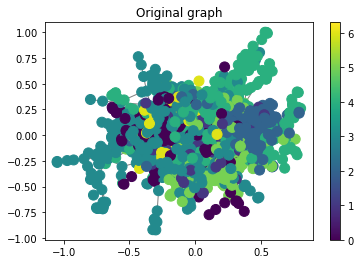

In [7]:
A_whole = to_dense_adj(data.edge_index).numpy()[0,:,:]
G_whole = nx.to_networkx_graph(A_whole)
nodes_cc = list(max(nx.connected_components(G_whole), key=len))
G_cc = G_whole.subgraph(nodes_cc).copy()

print(f'Number of nodes: {G_cc.number_of_nodes()}')
print(f'Number of edges: {G_cc.number_of_edges()}')
print(f'Number of classes: {dataset.num_classes}')

A = nx.to_numpy_array(G_cc)
L = np.diag(np.sum(A, axis=0)) - A
lambdas, V = np.linalg.eigh(L)
lambdas = np.real(lambdas)
print('Conn Comp:', np.sum(np.abs(lambdas) <= 1e-6))

labels = data.y[nodes_cc]

S = A

G = Graph(A)
G.set_coordinates()
plt.figure()
G.plot_signal(labels.numpy())
plt.title('Original graph')


### Set the expetiments

In [8]:
N_P = [.3]

# Model parameters
epochs =  500
lr = 0.001
loss = nn.MSELoss

Exps = [
        # {'type': 'BL', 'S': A, 'alpha': .05, 'legend': 'BL'},
        # {'type': 'TV', 'A': A, 'alpha': 5, 'legend': 'TV'},        
        # {'type': 'LR', 'L': L, 'alpha': 15, 'legend': 'LR'},
        # {'type': 'GTF', 'A': A, 'k': 3, 'lamb': .25, 'legend': 'GTF'},

        # # Non-convex
        # {'type': 'MED', 'S': A, 'legend': 'MED'},
        # {'type': 'GCNN', 'fts': 75, 'A': A, 'last_fts': 1, 'last_act': nn.Sigmoid(),
        #  'loss': loss(reduction='none'), 'legend': 'GCNN'},
        # {'type': 'GAT', 'fts': 70, 'A': A, 'heads': 3, 'last_fts': 1, 'last_act': nn.Sigmoid(),
        #  'loss': loss(reduction='none'), 'legend': 'GAT'},
        # {'type': 'KronAE', 'fts': 50, 'A': A, 'r': .5, 'last_act': nn.Sigmoid(),
        #  'loss': loss(reduction='none'), 'legend': 'K-GAE'},

        # Our models
        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*4, 'fts': [100]*3 + [1],
         'af': nn.ReLU(), 'laf':  nn.Sigmoid(), 'w_std': 1, 'in_std': 1, 'bn': False,
         'h_params': {'type': 'FixedH', 'S': 'A', 'hs': [.3, .5, .2], 'H_norm': False},
         'loss': loss(reduction='none'), 'legend': 'GCG'},
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [300, 1000, 1600, 2000] + [G.N]*2, 'fts': [50]*5 + [1],
         'af': nn.ReLU(), 'laf':  nn.Sigmoid(), 'w_std': 1, 'in_std': .5, 'bn': False, 'gamma': 0, 
         'loss': loss(reduction='none'), 'legend': 'GD'},

        # Unrolling
        # {'type': 'UNROLLING', 'arch': 'GUSC', 'fts': 64, 'dropout': 0, 'bin': True, 'legend': 'GUSC'},
        # {'type': 'UNROLLING', 'arch': 'GUSC', 'fts': 64, 'dropout': 0, 'bin': False, 'legend': 'GUSC'},
        # {'type': 'UNROLLING', 'arch': 'GUSC_2', 'fts': 50, 'dropout': 0, 'bin': True, 'legend': 'GUSC_2'},
        # {'type': 'UNROLLING', 'arch': 'GUSC_4', 'fts': 50, 'dropout': 0, 'bin': True, 'legend': 'GUSC_2'},

        # {'type': 'UNROLLING', 'arch': 'GUTF', 'fts': 64, 'dropout': 0, 'legend': 'GUTF'},
        # {'type': 'UNROLLING', 'arch': 'GUTF_2', 'fts': 50, 'dropout': 0, 'legend': 'GUTF_2'},
        ]

legend = [exp['legend'] for _, exp in enumerate(Exps)]

compute_matrices(Exps)


In [9]:
n_signals = 25

start_time = time.time()
err2, weights2 = denoise_signals(labels, n_signals, Exps, epochs, lr)
print('\n--- {} minutes ---'.format((time.time()-start_time)/60))

Labels: [0 1 2 3 4 5 6]
Noise: 0.3
(0,0) (0,1) (0,2) (0,3) (0,4) (0,5) (0,6) (0,7) (0,8) (0,9) (0,10) (0,11) (0,12) (0,13) (0,14) (0,15) (0,16) (0,17) (0,18) (0,19) (0,20) (0,21) (0,22) (0,23) (0,24) (1,0) (1,1) (1,2) (1,3) (1,4) (1,5) (1,6) (1,7) (1,8) (1,9) (1,10) (1,11) (1,12) (1,13) (1,14) (1,15) (1,16) (1,17) (1,18) (1,19) (1,20) (1,21) (1,22) (1,23) (1,24) (2,0) (2,1) (2,2) (2,3) (2,4) (2,5) (2,6) (2,7) (2,8) (2,9) (2,10) (2,11) (2,12) (2,13) (2,14) (2,15) (2,16) (2,17) (2,18) (2,19) (2,20) (2,21) (2,22) (2,23) (2,24) (3,0) (3,1) (3,2) (3,3) (3,4) (3,5) (3,6) (3,7) (3,8) (3,9) (3,10) (3,11) (3,12) (3,13) (3,14) (3,15) (3,16) (3,17) (3,18) (3,19) 

KeyboardInterrupt: 

In [ ]:
best_mean_err, std, _ = get_best_err(err2)
print_err_all0(labels)
print_err(best_mean_err, std, weights2)

Err per label: [0.0861167  0.16338028 0.29215292 0.15251509 0.11468813 0.0527163
 0.13843058]
Mean Err: 0.14285714285714285
N_P: [0.3]
BL (0.0): 	0.1503 +- 0.0534
TV (0.0): 	0.1414 +- 0.0697
LR (0.0): 	0.1041 +- 0.0383
GTF (0.0): 	0.1165 +- 0.0164
MED (0.0): 	0.1663 +- 0.0267
GCNN (5926.0): 	0.0938 +- 0.0307
GAT (16101.0): 	0.1383 +- 0.0642
K-GAE (5251.0): 	0.1361 +- 0.0365
GCG (20100.0): 	0.0888 +- 0.0399
GD (10050.0): 	0.1219 +- 0.0354


In [ ]:
# # Save data
# data = {
#     'seed': SEED,
#     'N_P': N_P,
#     'exps': Exps,
#     'err': err,
#     'err2': err2,
#     'lr': lr,
#     'weights': weights,
#     'weights2': weights2,
#     'legend': legend,
#     'fmts': [],
# }
# utils.save_results('cora_baselines', PATH, data)

SAVED as: c:\Users\Samuel\OneDrive - Universidad Rey Juan Carlos\Investigacion\Graph_Deep_Decoder ./results/cora/cora_baselines2022_03_31-08_39


In [ ]:
plt.show()